In [1]:
#To Try: TFIDF, Jccard Index,blog.ethanrosenthal.com
#Cosine SImilarity seems to be better than 
#Majority rules for cosine sim or distance
#Empty Fridge Pitch
#Remove measurements and other cooking
#Common Sense Validation for ingredients


%matplotlib inline
import pylab
import requests
import pymongo
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stop_words import get_stop_words
import os
import wordcloud
from textblob import TextBlob
import textblob
s=get_stop_words('english')+["'","dont","may","will","says","new","back",'',"go","one","can","big","first",'make','get','still','gets',"say"]
pd.set_option("display.max_rows",30)
from threading import Thread
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import scipy

In [2]:
connection=pymongo.MongoClient("mongodb://localhost")['recipes']['recipes']
recipe_list=list(connection.find())[2:]
for j in recipe_list:
    if 'Ingredients' in j:
        ingredient_string=""
        for x in j['Ingredients']:
            if 'Name' in x:
                ingredient_string=ingredient_string+str(x['Name'])+"|"
        j["ingredient_string"]=ingredient_string
        


In [3]:
df=pd.DataFrame(recipe_list)
df=df.set_index('Title')
df.drop(['ActiveMinutes','AdTags','AdminBoost','AllCategoriesText','BookmarkImageURL',
         'BookmarkSiteLogo', 'BookmarkURL','Collection', 'CollectionID', 'CreationDate','Data',
       'Description','HeroPhotoUrl', 'ImageSquares', 'IngredientsTextBlock','IsBookmark', 'IsPrivate', 'IsRecipeScan', 'IsSponsored',
       'LastModified', 'MaxImageSquare','MedalCount','MenuCount','Message','Microcategory','NotesCount','Poster','VariantOfRecipeID','VerifiedByClass','VerifiedDateTime','StatusCode','_id'],axis=1,inplace=True)
ingredients_list=df.ingredient_string.str.lower().str.replace("[^a-z|\s]",'').str.replace("\s",'|').str.split('|').apply(pd.Series, 1).stack()
ingredients_list.index= ingredients_list.index.droplevel(-1)


In [4]:
result=ingredients_list[~ingredients_list.isin(s)].to_frame()
result.columns=['word']
x=result['word'].value_counts()


In [5]:
wordcloud_text=df.ingredient_string.str.lower().str.replace("[^a-z\s]",' ').apply(pd.Series, 1).stack()
wordcloud_text.index=wordcloud_text.index.droplevel(-1)
print(wordcloud_text)

Title
Karens Chicken Salad                                        oz  white chunk granny smith apples  c...
Peppermint Filling                                                                         see below 
Kale Pesto (Phytopia)                               kale  remove ribs and stems garlic basil leave...
Jack-O-Lantern Cookies                              pillsbury cream cheese frosting vanilla flavor...
Kamillas Spice Bread-In-A-Jar                       baking soda baking powder salt cinnamon cloves...
Kangaroo Tail Soup (In Pressure Cooker)             large kangaroo tail carrots  sliced sticks of ...
Jalapeno Chutney                                    fresh mangos raisins light brown sugar sugar f...
Jalapeno Mustard                                    prepared mustard onion jalapeno pepper salt wh...
Kats Chunky Chicken Stew                            stalks celery  cut into    skinless chicken br...
Jalapeno Poppers                                    fresh green and or red j

/usr/local/lib/python3.4/site-packages/PIL/ImageDraw.py:99: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


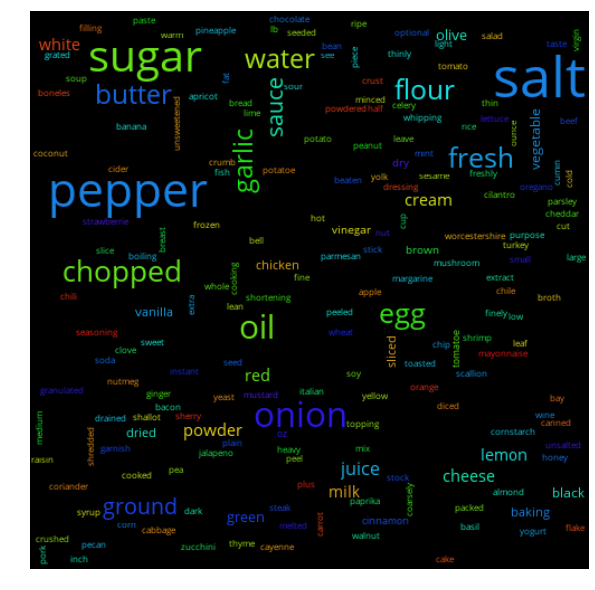

In [13]:
#Show them as word clouds
text=''
for word in wordcloud_text:
    text=text+" "+word
w = wordcloud.WordCloud(max_font_size=50, relative_scaling=1,width = 500, height=500, font_path='/Users/theo/Documents/InsightFoodProject/open-sans/OpenSans-Regular.ttf').generate(text)
plt.figure( figsize=(15,10) )
plt.imshow(w)
plt.axis("off")
pylab.savefig('foo.png')

In [14]:
ingredients_sentence=df.ingredient_string.str.replace("[^a-zA-Z|;\s]",' ').str.split('|').apply(pd.Series, 1).stack()
ingredients_sentence=ingredients_sentence.str.split(';').str.get(0).str.title()
ingredients_sentence.index=ingredients_sentence.index.droplevel(-1)

In [15]:
ingredients_sentence=ingredients_sentence.to_frame()


In [16]:
ingredients_sentence.columns=['Ingredients']

In [17]:
ingredients_sentence=ingredients_sentence.groupby(ingredients_sentence.index)['Ingredients'].apply(lambda x: "%s" % ', '.join(x))

In [18]:
ingredients_sentence=ingredients_sentence.reset_index()
df=df.reset_index()

In [19]:
df=pd.merge(left=df,right=ingredients_sentence, left_on='Title', right_on='Title')


In [20]:
df.head()

,Title,Category,Cuisine,FavoriteCount,ImageURL,Ingredients_x,Instructions,NutritionInfo,PrimaryIngredient,RecipeID,ReviewCount,StarRating,Subcategory,TotalMinutes,WebURL,YieldNumber,YieldUnit,ingredient_string,Ingredients_y
0,Karens Chicken Salad,Salad,American,0,None,"[{'Quantity': 1, 'Unit': 'cn', 'DisplayIndex':...",Combine all ingredients; toss to combine. P...,"{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Chicken,53,0,0,Meat and Seafood,NaN,http://www.bigoven.com/recipe/karens-chicken-s...,4,Servings,(12-1/2 oz) white chunk|Granny smith apples; c...,"Oz White Chunk, Granny Smith Apples, ..."
1,Peppermint Filling,None,American,0,None,"[{'Quantity': 1, 'MetricUnit': '', 'DisplayInd...",Blend 3 Tbls. cream & 1/4 tsp. peppermint extr...,"{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Cookies,4043,0,0,None,NaN,http://www.bigoven.com/recipe/peppermint-filli...,1,Serving,See below|,"See Below,"
2,Kale Pesto (Phytopia),Marinades and Sauces,American,2,None,"[{'Quantity': 0.75, 'Unit': 'lb', 'DisplayInde...",1. Wash and stem the kale. Leaving water on le...,"{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Herbs,50,0,0,None,NaN,http://www.bigoven.com/recipe/kale-pesto-phyto...,12,Servings,Kale; remove ribs and stems|Garlic|Basil leave...,"Kale, Garlic, Basil Leaves, Lemon And Or Lime,..."
3,Jack-O-Lantern Cookies,Desserts,American,0,None,"[{'Quantity': 0.5, 'Unit': 'cn', 'DisplayIndex...","1. In small saucepan, combine frosting and can...","{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Cookies,1,0,0,Cookies and Bars,20,http://www.bigoven.com/recipe/jack-o-lantern-c...,1,Serving,Pillsbury Cream Cheese Frosting|Vanilla-Flavor...,"Pillsbury Cream Cheese Frosting, Vanilla Flavo..."
4,Kamillas Spice Bread-In-A-Jar,Desserts,American,1,None,"[{'Quantity': 2, 'Unit': 'ts', 'DisplayIndex':...",Cream shortening and sugar in mixer bowl until...,"{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Grains,51,2,4,None,NaN,http://www.bigoven.com/recipe/kamillas-spice-b...,7,Servings,Baking soda|Baking Powder|Salt|Cinnamon|Cloves...,"Baking Soda, Baking Powder, Salt, Cinnamon, Cl..."


In [21]:
df=df[~df['Ingredients_x'].isnull()]
df=df[~df['Instructions'].isnull()]
df=df[~(df['Category']=='Desserts')]
df=df[~(df['Category']=='Drinks')]
df=df[~(df['Category']=='None   ')]
df['Number of Ingredients']=pd.Series(np.asarray([len(x) for x in df.Ingredients_y.values]),index=df.index)
df.loc[df.Cuisine.str.title()=="",'Cuisine']="Unclassified"

In [22]:
df.index=df.Title



In [23]:
df.drop_duplicates('Title')

,Title,Category,Cuisine,FavoriteCount,ImageURL,Ingredients_x,Instructions,NutritionInfo,PrimaryIngredient,RecipeID,ReviewCount,StarRating,Subcategory,TotalMinutes,WebURL,YieldNumber,YieldUnit,ingredient_string,Ingredients_y,Number of Ingredients
Title,,,,,,,,,,,,,,,,,,,,
Karens Chicken Salad,Karens Chicken Salad,Salad,American,0,None,"[{'Quantity': 1, 'Unit': 'cn', 'DisplayIndex':...",Combine all ingredients; toss to combine. P...,"{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Chicken,53,0,0.00,Meat and Seafood,NaN,http://www.bigoven.com/recipe/karens-chicken-s...,4,Servings,(12-1/2 oz) white chunk|Granny smith apples; c...,"Oz White Chunk, Granny Smith Apples, ...",82
Peppermint Filling,Peppermint Filling,None,American,0,None,"[{'Quantity': 1, 'MetricUnit': '', 'DisplayInd...",Blend 3 Tbls. cream & 1/4 tsp. peppermint extr...,"{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Cookies,4043,0,0.00,None,NaN,http://www.bigoven.com/recipe/peppermint-filli...,1,Serving,See below|,"See Below,",11
Kale Pesto (Phytopia),Kale Pesto (Phytopia),Marinades and Sauces,American,2,None,"[{'Quantity': 0.75, 'Unit': 'lb', 'DisplayInde...",1. Wash and stem the kale. Leaving water on le...,"{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Herbs,50,0,0.00,None,NaN,http://www.bigoven.com/recipe/kale-pesto-phyto...,12,Servings,Kale; remove ribs and stems|Garlic|Basil leave...,"Kale, Garlic, Basil Leaves, Lemon And Or Lime,...",115
Kangaroo Tail Soup (In Pressure Cooker),Kangaroo Tail Soup (In Pressure Cooker),"Soups, Stews and Chili",Asian,1,None,"[{'Quantity': 1, 'Unit': '', 'DisplayIndex': 0...",Separate the joints of the roo tail. Brown the...,"{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Soup,52,0,0.00,None,NaN,http://www.bigoven.com/recipe/kangaroo-tail-so...,4,Servings,"Large kangaroo tail|Carrots, sliced|Sticks of ...","Large Kangaroo Tail, Carrots Sliced, Sticks O...",184
Jalapeno Chutney,Jalapeno Chutney,Marinades and Sauces,Mexican,4,None,"[{'Quantity': 4, 'Unit': 'medium', 'DisplayInd...","This stuff is great with pork, chicken or tur...","{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Jalapeno,3,0,3.00,Sauce,0,http://www.bigoven.com/recipe/jalapeno-chutney/3,1,Serving,Fresh mangos|Raisins|Light brown sugar|Sugar|F...,"Fresh Mangos, Raisins, Light Brown Sugar, Suga...",182
Jalapeno Mustard,Jalapeno Mustard,Marinades and Sauces,Mexican,4,http://redirect.bigoven.com/pics/rs/640/jalape...,"[{'Quantity': 2, 'Unit': 'c', 'DisplayIndex': ...","Combine first 5 ingredients, stirring well.\r\...","{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Jalapeno,4,3,4.00,Sauce,0,http://www.bigoven.com/recipe/jalapeno-mustard/4,2,Cups,Prepared mustard|Onion|Jalapeno Pepper|Salt|Wh...,"Prepared Mustard, Onion, Jalapeno Pepper, Salt...",73
Kats Chunky Chicken Stew,Kats Chunky Chicken Stew,"Soups, Stews and Chili",American,0,None,"[{'Quantity': 3, 'Unit': '', 'DisplayIndex': 0...",Place chicken pieces in a crock pot and slow c...,"{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Chicken,54,0,0.00,Stews,NaN,http://www.bigoven.com/recipe/kats-chunky-chic...,6,Servings,"Stalks celery; cut into 1""|Skinless chicken br...","Stalks Celery, Skinless Chicken Breasts, Carro...",123
Jalapeno Poppers,Jalapeno Poppers,Bread,Mexican,79,http://redirect.bigoven.com/pics/rs/640/jalape...,"[{'Quantity': 10, 'Unit': '', 'DisplayIndex': ...",Cut each pepper in half lengthwise. Remove s...,"{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Jalapeno,5,4,4.75,Spicy,NaN,http://www.bigoven.com/recipe/jalapeno-poppers/5,10,Servings,Fresh green and/or red jalapenos|Cheddar chees...,"Fresh Green And Or Red Jalapenos, Cheddar Chee...",131
Kats Cranberry-Port Relish,Kats Cranberry-Port Relish,Marinades and Sauces,American,0,None,"[{'Quantity': 3, 'Unit': 'c', 'DisplayIndex': ...","In a 3-4 quart pan, combine cranberries, onion...","{'PolyFat': 0, 'SingularYieldUnit': 'Paid API ...",Cranberry,55,0,0.00,None,NaN,http://www.bigoven.com/recipe/kats-cranberry-p...,4,Ser

In [24]:
#To Add- Beer,Wine,Cheese,chicken breast,coffee,steak,pork chop,peanut
Description=df[['Ingredients_y','Title','Category','Cuisine','Instructions','WebURL']]
additional_ingredients=['tofu','star anise','five spice','pizza','squash','lobster','chickpea','bok choy','taco','liver',
                        'tongue','brisket','lemongrass','curry','tuna','salmon','teriyaki','skirt steak','chicken thigh',
                       'drumstick','chicken wing','fish sauce','spare ribs']#'beer','wine','coffee','peanut']
                        #'coffee','steak','pork chop','peanut','bean curd']
Final_Description=Description[0:8000]
for ingredient in additional_ingredients:
    recipes=Description[Description.Ingredients_y.str.lower().str.contains(ingredient)]
    Final_Description=Final_Description.combine_first(recipes)
print(len(Final_Description))
Final_Description=Final_Description.drop_duplicates('Title')
print(len(Final_Description))

28002
9374


In [25]:
Final_Description=Final_Description.dropna()
len(Final_Description)

7137

In [28]:
Flavor_Profile1=['soy sauce','scallion','sugar','cornstarch','ginger']
Flavor_Profile2=['bean sprout', 'shrimp', 'peanut', 'fish sauce']
Flavor_Profile3=['turmeric', 'cumin', 'garlic', 'onion']
Flavor_Profile4=["basil", "oregano", "cheese", "olive oil", "garlic"]


In [33]:
t1=Final_Description[np.logical_and.reduce([Final_Description['Ingredients_y'].str.lower().str.contains(word) 
                                            for word in Flavor_Profile1])]
print(t1.Cuisine.value_counts())
t2=Final_Description[np.logical_and.reduce([Final_Description['Ingredients_y'].str.lower().str.contains(word) 
                                            for word in Flavor_Profile2])]
print(t2.Cuisine.value_counts())
t3=Final_Description[np.logical_and.reduce([Final_Description['Ingredients_y'].str.lower().str.contains(word) 
                                            for word in Flavor_Profile3])]
print(t3.Cuisine.value_counts())
t4=Final_Description[np.logical_and.reduce([Final_Description['Ingredients_y'].str.lower().str.contains(word) 
                                            for word in Flavor_Profile4])]
print(t4.Cuisine.value_counts())

Chinese     6
American    3
Thai        1
Name: Cuisine, dtype: int64
Thai            6
American        4
Unclassified    3
Asian           1
Name: Cuisine, dtype: int64
American          21
Indian             7
Thai               4
Unclassified       3
Moroccan           1
India              1
Middle Eastern     1
Mexican            1
Name: Cuisine, dtype: int64
American        19
Italian          4
Unclassified     1
Greek            1
Name: Cuisine, dtype: int64


In [ ]:
recipe_names=to_csv_smaller
query=['scallion','shrimp']
flavor_profile=['pepper', 'lemon juice', 'sugar', 'shrimp', 'scallion', 'soy sauce', 'salt', 'ginger', 'cilantro', 'vegetable oil', 'onion', 'garlic', 'butter', 'olive oil']
if not Description[np.logical_and.reduce([Description['Ingredients_y'].str.lower().str.contains(word) for word in flavor_profile])].empty:
       print(len(Description[np.logical_and.reduce([Description['Ingredients_y'].str.lower().str.contains(word) for word in flavor_profile])]))
else:
    if not Description[np.logical_and.reduce([Description['Ingredients_y'].str.lower().str.contains(word) for word in query])].empty:
        print('We are good')
        print(len(Description[np.logical_and.reduce([Description['Ingredients_y'].str.lower().str.contains(word) for word in query])]['Title']))
    else: 
        test=pd.DataFrame()
        for ingredient in query:
            test=pd.concat([test,Description[Description['Ingredients_y'].str.lower().str.contains(ingredient)][:5]])
            print(test)
        if test.empty:
            print('Our apologies the culinary skills are limited')

In [ ]:
for i in range(0,10):
    print("Recipe Number "+str(i))
    for word in str(ingredients_sentence[i]).title().split():
        print(word)
        blob=TextBlob(word)
        if not blob.tags[0][1].startswith('N'):
            print(word+' is not a Noun!')
            ingredients_sentence.set_value(i,str(ingredients_sentence[i]).title().replace(word,''))
            verbs.set_value(i,word)
        else:
            ingredients_sentence.set_value(i,str(ingredients_sentence[i]).title().replace(word,textblob.Word(word).lemmatize()))
        



In [22]:
Final_Description.loc[:,'ingredients_lower']=Final_Description.Ingredients_y.str.replace(',','').str.lower()


In [23]:
Final_Description.loc[:,'titles_formatted']=Final_Description.Title.str.replace('"','').str.lower()
Final_Description.drop(['Ingredients_y','Title'],axis=1,inplace=True)
Final_Description.head()




,Category,Cuisine,Instructions,WebURL,ingredients_lower,titles_formatted
Title,,,,,,
Mexican Chicken Soup,Main Dish,Unclassified,"In a large nonstick skillet, saute chicken in ...",http://www.bigoven.com/recipe/mexican-chicken-...,boneless skinless chicken breasts canola oil w...,mexican chicken soup
"""Arroz con pollo del Travieso”",Side Dish,Latinoamerican Fusion,Wash and pat-dry up to six chicken thighs (the...,http://www.bigoven.com/recipe/arroz-con-pollo-...,mahatma long grain white rice saz n goya co...,arroz con pollo del travieso”
"""Beau Monde"" Dip",Marinades and Sauces,American,"Mix well, chill, and serve with dipping veggie...",http://www.bigoven.com/recipe/beau-monde-dip/1...,dried minced onion dill weed dried parsley may...,beau monde dip
"""Beef"" and Bean Burrito",Main Dish,American,Prepare taco mix according to package directio...,http://www.bigoven.com/recipe/beef-and-bean-bu...,tortillas flour taco sauce refried beans chee...,beef and bean burrito
"""Best Ever"" Pizza Sauce",Marinades and Sauces,Italian,From: Gerald Edgerton <jerrye@wizard.com> D...,http://www.bigoven.com/recipe/best-ever-pizza-...,onions prince pizza sauce basil salt oz t...,best ever pizza sauce


In [24]:
cluster_ingredients=Final_Description.ingredients_lower.tolist()
cluster_title=Final_Description.titles_formatted.tolist()



In [ ]:
print(cluster_ingredients[1:10])

In [ ]:
test=CountVectorizer(stop_words='english',lowercase=True)
x=test.fit_transform(cluster_ingredients)
y=test.fit_transform(cluster_title)
Final_Description.drop(["titles_formatted","ingredients_lower"],axis=1,inplace=True)

In [26]:
new_test=CountVectorizer(stop_words='english',lowercase=True)
X=new_test.fit_transform(cluster_ingredients)



In [80]:
import lda
model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)
model.fit(X)
topic_word = model.topic_word_ 

In [56]:
new_test.vocabulary_

{'jerk': 2205,
 'peeled': 3227,
 'minched': 2761,
 'chocolate': 864,
 'nonfat': 2953,
 'tools': 4652,
 'snapper': 4153,
 'alubhukharas': 81,
 'mince': 2759,
 'secret': 3955,
 'exchange': 1510,
 'choice': 867,
 'litres': 2478,
 'dion': 1316,
 'ca': 607,
 'breakfast': 494,
 'coloring': 984,
 'bow': 458,
 'chi': 810,
 'takjes': 4478,
 'rum': 3812,
 'prefably': 3487,
 'bear': 280,
 'sumac': 4413,
 'emeril': 1446,
 'beatersr': 286,
 'chianti': 813,
 'scallons': 3912,
 'yolk': 5049,
 'kneading': 2320,
 'lunch': 2529,
 'taking': 4477,
 'beansprouts': 279,
 'oliv': 3013,
 'garllic': 1769,
 'hefty': 2017,
 'aioli': 43,
 'rub': 3807,
 'stirfrying': 4339,
 'globe': 1827,
 'bread': 487,
 'confit': 1015,
 'crustless': 1153,
 'pjxg': 3376,
 'consistency': 1018,
 'low': 2515,
 'capers': 666,
 'carbonated': 680,
 'handful': 1976,
 'lavosh': 2382,
 'rolled': 3765,
 'toppings': 4658,
 'soda': 4167,
 'yuca': 5057,
 'unsulphured': 4796,
 'spirits': 4247,
 'lots': 2508,
 'sheet': 4023,
 'skin': 4104,
 'heu

In [82]:
count=0
with open('lda.txt','w') as f:
    for topic_dist in topic_word:
        f.write('New Topic '+ str(count)+' \n')
        count=count+1
        for index in topic_dist.argsort()[-50:][::-1]:
            for key,value in new_test.vocabulary_.items():
                if value==index:
                    f.write(key +', ')
        f.write('\n')


In [ ]:
tfidf_transformer = TfidfVectorizer()
xx=tfidf_transformer.fit_transform(cluster_ingredients)
yy=tfidf_transformer.fit_transform(cluster_title)

In [ ]:
Recipe_dict = Final_Description.T.to_dict().values()
test2=DictVectorizer()
z=test2.fit_transform(Recipe_dict)



In [ ]:
try1=scipy.sparse.hstack([x,y,z])
try2=scipy.sparse.hstack([xx,yy,z])
try3=scipy.sparse.hstack([x,y])
try4=scipy.sparse.hstack([xx,yy])

In [ ]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(try4)


In [ ]:
distances, indices = nbrs.kneighbors(try4)
for i in range(6000,6050):
    test=indices[i]
    print('Cluster:')
    for x in test:
        print(Final_Description.ix[x])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
ahh1=cosine_similarity(try1, try1)
ahh2=cosine_similarity(try2, try2)
ahh3=cosine_similarity(try3, try3)
ahh4=cosine_similarity(try4, try4)

In [ ]:
for x in ahh4[1:100]:
    print('Cluster:')
    for y in np.argpartition(x,-5)[-5:]:
        print(Final_Description.ix[y])

In [ ]:
recipe_names.reset_index()
Description.reset_index()
recipe_names.index.name

In [96]:
count=0
images=df[df.ImageURL.notnull()]
for x in images['ImageURL']:
    print(x)
    count=count+1
    if count>10:
        break
        
images.head()

http://redirect.bigoven.com/pics/rs/640/jalapeno-mustard.jpg
http://redirect.bigoven.com/pics/rs/640/jalapeno-poppers-11.jpg
http://redirect.bigoven.com/pics/rs/640/jalapeno-steak-2.jpg
http://redirect.bigoven.com/pics/rs/640/jamaican-chicken-salad.jpg
http://redirect.bigoven.com/pics/rs/640/jamaican-jerk-spice.jpg
http://redirect.bigoven.com/pics/rs/640/jeffs-taco-meat-seasoning.jpg
http://redirect.bigoven.com/pics/rs/640/killer-bread-12.jpg
http://redirect.bigoven.com/pics/rs/640/kolacky-3.jpg
http://redirect.bigoven.com/pics/rs/640/kosher-dill-pickles-2.jpg
http://redirect.bigoven.com/pics/rs/640/kringla.jpg
http://redirect.bigoven.com/pics/rs/640/lamb-chhewyala-classic-nepali-grill.jpg


,Title,Category,Cuisine,FavoriteCount,ImageURL,Ingredients_x,Instructions,NutritionInfo,PrimaryIngredient,RecipeID,ReviewCount,StarRating,Subcategory,TotalMinutes,WebURL,YieldNumber,YieldUnit,ingredient_string,Ingredients_y,Number of Ingredients
Title,,,,,,,,,,,,,,,,,,,,
Jalapeno Mustard,Jalapeno Mustard,Marinades and Sauces,Mexican,4,http://redirect.bigoven.com/pics/rs/640/jalape...,"[{'PreparationNotes': None, 'MetricUnit': 'ml'...","Combine first 5 ingredients, stirring well.\r\...","{'TotalCarbs': 0, 'PotassiumPct': 0, 'SatFat':...",Jalapeno,4,3,4.00,Sauce,0,http://www.bigoven.com/recipe/jalapeno-mustard/4,2,Cups,Prepared mustard|Onion|Jalapeno Pepper|Salt|Wh...,"Prepared Mustard, Onion, Jalapeno Pepper, Salt...",73
Jalapeno Poppers,Jalapeno Poppers,Bread,Mexican,79,http://redirect.bigoven.com/pics/rs/640/jalape...,"[{'PreparationNotes': '', 'MetricUnit': '', 'M...",Cut each pepper in half lengthwise. Remove s...,"{'TotalCarbs': 0, 'PotassiumPct': 0, 'SatFat':...",Jalapeno,5,4,4.75,Spicy,NaN,http://www.bigoven.com/recipe/jalapeno-poppers/5,10,Servings,Fresh green and/or red jalapenos|Cheddar chees...,"Fresh Green And Or Red Jalapenos, Cheddar Chee...",131
Jalapeno Steak,Jalapeno Steak,Main Dish,Mexican,6,http://redirect.bigoven.com/pics/rs/640/jalape...,"[{'PreparationNotes': 'peeled', 'MetricUnit': ...","Combine the jalapenos, garlic, black pepper, s...","{'TotalCarbs': 0, 'PotassiumPct': 0, 'SatFat':...",Beef,6,0,0.00,Meat - Steaks and Chops,NaN,http://www.bigoven.com/recipe/jalapeno-steak/6,4,Servings,Garlic|Cracked black pepper|Coarse salt|Lime j...,"Garlic, Cracked Black Pepper, Coarse Salt, Lim...",87
Jamaican Chicken Salad,Jamaican Chicken Salad,Salad,Caribbean,7,http://redirect.bigoven.com/pics/rs/640/jamaic...,"[{'PreparationNotes': '', 'MetricUnit': 'ml', ...",*Jamaican jerk seasoning: Combine 2 teaspoons ...,"{'TotalCarbs': 0, 'PotassiumPct': 0, 'SatFat':...",Chicken,9,3,4.00,Meat and Seafood,0,http://www.bigoven.com/recipe/jamaican-chicken...,4,Servings,Bottled fat-free honey mustard dressing|Finely...,"Bottled Fat Free Honey Mustard Dressing, Finel...",187
Jamaican Jerk Spice,Jamaican Jerk Spice,None,Caribbean,2,http://redirect.bigoven.com/pics/rs/640/jamaic...,"[{'PreparationNotes': 'up to 3', 'MetricUnit':...",These are some pretty good recipes for chilehe...,"{'TotalCarbs': 0, 'PotassiumPct': 0, 'SatFat':...",Pepper,10,0,0.00,None,NaN,http://www.bigoven.com/recipe/jamaican-jerk-sp...,9,tablespoons,Cayenne pepper|Cinnamon|Nutmeg|Allspice|Chives...,"Cayenne Pepper, Cinnamon, Nutmeg, Allspice, Ch...",92


In [ ]:
Description[Description['word'].isnull()]

In [ ]:
from_csv_test=pd.read_csv('Recipes.csv') 
from_csv_test.set_index('Title')


In [ ]:
recipe_names=pd.read_csv('Recipes.csv') 
recipe_names.set_index('Title')
recipe_names[recipe_names['word'].isnull()]

In [ ]:
print(recipe_names[np.logical_and.reduce([recipe_names['word'].str.lower().str.contains(word,na=False) for word in query])]['Cuisine'])

In [ ]:
test=TextBlob(str(ingredients_sentence[4]).title())
for word, tag in test.tags:
  print(word+str(tag))
test2=TextBlob(str(ingredients_sentence[4]).title())
print(test2.noun_phrases)

In [ ]:
cuisines=['Afghan', 'African', 'American', 'American-South', 'Asian', 'Australian', 'Brazilian', 'Cajun', 'Canadian', 'Caribbean', 'Chinese', 'Croatian', 'Cuban', 'Dessert', 'Eastern European', 'English', 'French', 'German', 'Greek', 'Hawaiian', 'Hungarian', 'India', 'Indian', 'Irish', 'Italian', 'Japanese', 'Jewish','Jamacian' 'Korean', 'Latin', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Moroccan', 'Polish', 'Russian', 'Scandanavian', 'Seafood', 'Southern', 'Southwestern', 'Spanish', 'Tex-Mex', 'Thai', 'Vegan', 'Vegetarian', 'Vietnamese','Shanghainese','Taiwanese','Sicilian','Cantonese','Fusion']

In [ ]:
for cuisine in cuisines:
    url_1='http://api.bigoven.com/recipes?api_key=58RxI6clGvQj87yeXMrdcJ7Y55sOlDoQ&any_kw='+cuisine+'&&pg='+str(i)+'&rpp=10'
    url_2='http://api.bigoven.com/recipes?api_key=QP81d0EB12afy94IDZ925k7xcta0gO8&any_kw='cuisine+'&&pg='+str(i+1)+'&rpp=10'
    r=requests.get(url_1,headers={"Content-Type":"application/json","Accept":"application/json"})
    s=requests.get(url_2,headers={"Content-Type":"application/json","Accept":"application/json"})
    json.load()
        
        

In [ ]:
test=requests.get(url,headers={"Content-Type":"application/json","Accept":"application/json"})
print(test.text)

In [ ]:
df.ix[1,:]['Title']

In [ ]:
check=json.loads(test.text)


In [ ]:
check['Results'][1]['RecipeID']

In [ ]:
1+1

In [ ]:
def thread1(df,verbs1,verb_count1):
    for x in range(0,15000):
        blob=TextBlob(df[x])
        v=[word for word,tag in blob.tags if tag.startswith('V')]
        verbs1[x]=v
        verb_count1[x]=len(v)
        if x % 100==0:
            print(x)


def thread2(df,verbs2,verb_count2):
    for x in range(15000,30233):
        blob=TextBlob(df[x])
        v=[word for word,tag in blob.tags if tag.startswith('V')]
        verbs2[x]=v
        verb_count2[x]=len(v)
        if x % 100==0:
            print(x)
            
verbs1=np.empty(30233,dtype=list)
verb_count1=np.zeros(30233)
verbs2=np.empty(30233,dtype=list)
verb_count2=np.zeros(30233)
threads = [None]*2
threads[0] = Thread(target=thread1, args=(pd.Series(df.Instructions),verbs1,verb_count1))
threads[0].start()
threads[1] = Thread(target=thread2, args=(pd.Series(df.Instructions),verbs2,verb_count2))
threads[1].start()


pd.Series(verbs1).to_csv('verbs1.csv')
pd.Series(verbs2).to_csv('verbs2.csv')
pd.Series(verb_count1).to_csv('verbscount1.csv')
pd.Series(verb_count2).to_csv('verbscount2.csv')